In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\CLOV_2021.csv')

In [3]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'clov', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,2021-01-05,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     261 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOV Close Price

### Without Normalization

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '5Dir', '2D%Change', '4Dir', '3D%Change', 'Open', '7D%Change', 'Low', 'Dir', '6D%Change', 'Daily%Change', '7Dir', '4D%Change', '2Dir', '6Dir', '3Dir', 'Volume', '5D%Change', 'SD_log', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
3,14.00,2,-2.403202,0.0,15606600.0,0.0,14.86,0.619409,14.270,-12.820516,...,-8.050313,0.999128,1.0,-8.739079,0.0,0.0,-3.114647,2.715913,-6.342087,14.62
4,14.01,3,-4.240765,0.0,13886000.0,0.0,14.56,-12.609241,13.800,-10.313899,...,-6.542053,0.138233,0.0,-11.949683,0.0,0.0,-3.647624,1.148243,-7.223328,14.00
5,13.24,4,0.071430,0.0,13765600.0,1.0,14.15,-11.886789,13.570,-7.157057,...,-4.172364,0.606492,0.0,-6.475296,0.0,0.0,-12.546818,1.833987,-3.578799,14.01
6,13.75,1,-5.496077,0.0,13851400.0,0.0,13.87,-11.615486,13.100,-8.878183,...,-5.428573,0.436696,0.0,-9.439125,0.0,0.0,-16.729559,1.547585,-17.353312,13.24
7,13.73,2,3.851966,0.0,13329600.0,1.0,13.69,-5.950752,13.271,-14.169790,...,-1.855819,0.395507,0.0,-1.785714,0.0,0.0,-8.210945,1.485137,-13.522011,13.75


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
241,4.09,2,3.274556,1.0,10732300.0,1.0,4.020,-0.726397,3.990,-7.239823,...,-0.001667,0.0,3.015072,0.0,0.0,1.485147,0.998334,-3.301884,4.10,4.09
242,4.20,3,-0.243896,0.0,7689900.0,0.0,4.083,2.763822,4.040,-3.537727,...,-0.194293,1.0,-2.386633,0.0,1.0,-0.968522,0.823417,1.237628,4.09,4.20
243,4.05,0,2.689478,1.0,8830600.0,1.0,4.080,0.238658,4.050,3.960392,...,-0.382827,1.0,5.793445,1.0,1.0,5.527633,0.681931,1.694908,4.20,4.05
244,3.89,1,-3.571420,0.0,7262200.0,0.0,4.160,2.015117,4.025,-1.937044,...,0.087610,1.0,-1.219505,0.0,1.0,-3.341286,1.091562,1.758798,4.05,3.89
245,3.74,2,-3.950619,0.0,10949100.0,0.0,4.017,-5.121946,3.835,-2.261304,...,-0.075867,0.0,-4.889977,0.0,0.0,-2.015111,0.926939,-7.159903,3.89,3.74


In [7]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.46379650293898705
0.46379650293898705


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'CLOV_woSentiment_ClosePrice_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0214
Epoch 1: val_loss improved from inf to 0.02063, saving model to CLOV_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 4s 72ms/step - loss: 0.0214 - val_loss: 0.0206
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0121
Epoch 2: val_loss improved from 0.02063 to 0.01378, saving model to CLOV_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 0s 14ms/step - loss: 0.0121 - val_loss: 0.0138
Epoch 3/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0113
Epoch 3: val_loss improved from 0.01378 to 0.00695, saving model to CLOV_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 0s 17ms/step - loss: 0.0108 - val_loss: 0.0069
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0085
Epoch 4: val_loss improved from 0.00695 to 0.00228, saving model to CLOV_woSentiment_CloseP

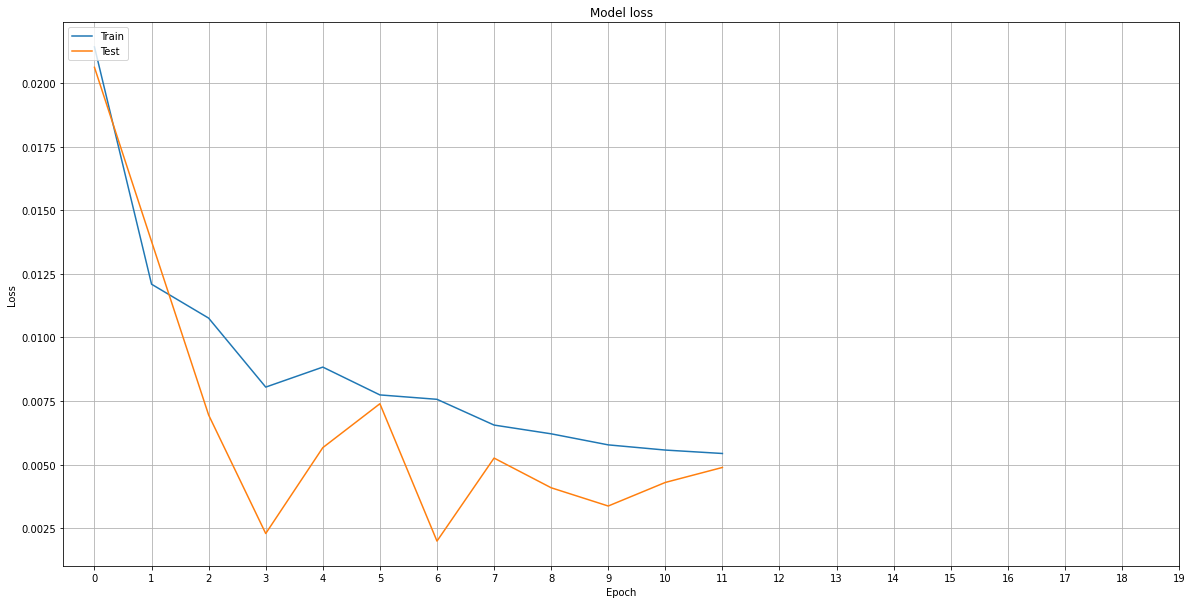

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.56
Mean Absolute Percentage Error (MAPE): 10.81 %
Median Absolute Percentage Error (MDAPE): 9.96 %


,MAE,MAPE,MDAPE
0,0.558396,10.81468,9.963392


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

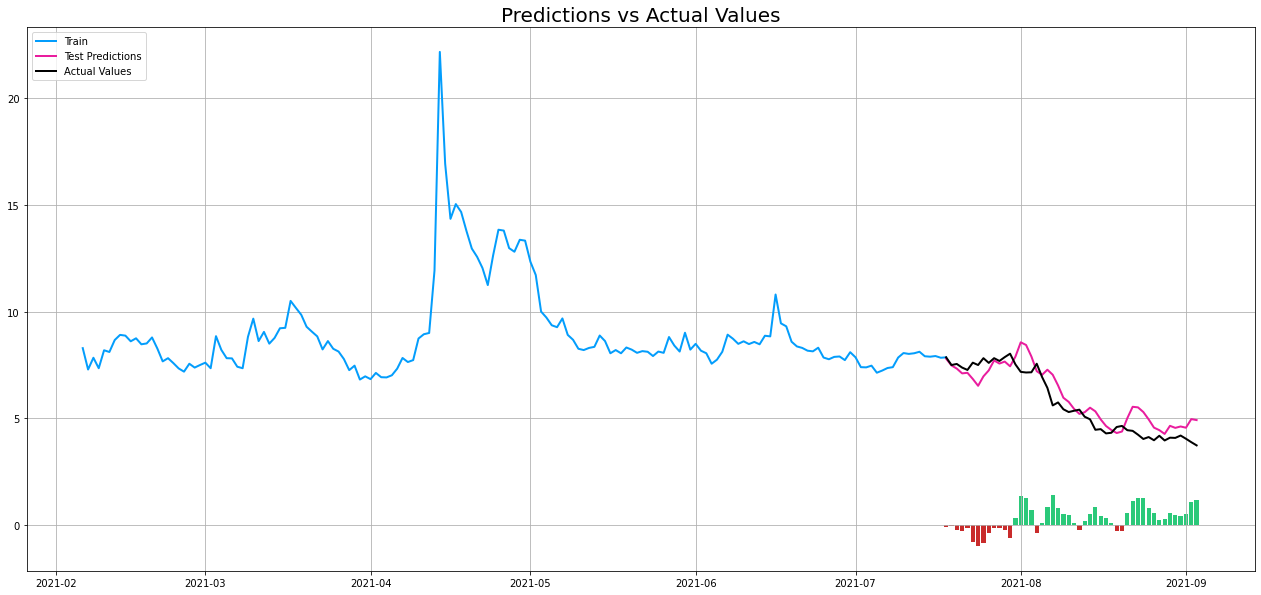

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '5Dir', '2D%Change', '4Dir', '3D%Change', 'Open', '7D%Change', 'Low', 'Dir', '6D%Change', 'Daily%Change', '7Dir', '4D%Change', '2Dir', '6Dir', '3Dir', 'Volume', '5D%Change', 'SD_log', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
3,14.00,2,-2.403202,0.0,15606600.0,0.0,14.86,0.619409,14.270,-12.820516,...,-8.050313,0.999128,1.0,-8.739079,0.0,0.0,-3.114647,2.715913,-6.342087,14.62
4,14.01,3,-4.240765,0.0,13886000.0,0.0,14.56,-12.609241,13.800,-10.313899,...,-6.542053,0.138233,0.0,-11.949683,0.0,0.0,-3.647624,1.148243,-7.223328,14.00
5,13.24,4,0.071430,0.0,13765600.0,1.0,14.15,-11.886789,13.570,-7.157057,...,-4.172364,0.606492,0.0,-6.475296,0.0,0.0,-12.546818,1.833987,-3.578799,14.01
6,13.75,1,-5.496077,0.0,13851400.0,0.0,13.87,-11.615486,13.100,-8.878183,...,-5.428573,0.436696,0.0,-9.439125,0.0,0.0,-16.729559,1.547585,-17.353312,13.24
7,13.73,2,3.851966,0.0,13329600.0,1.0,13.69,-5.950752,13.271,-14.169790,...,-1.855819,0.395507,0.0,-1.785714,0.0,0.0,-8.210945,1.485137,-13.522011,13.75


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
241,4.09,2,3.274556,1.0,10732300.0,1.0,4.020,-0.726397,3.990,-7.239823,...,-0.001667,0.0,3.015072,0.0,0.0,1.485147,0.998334,-3.301884,4.10,4.09
242,4.20,3,-0.243896,0.0,7689900.0,0.0,4.083,2.763822,4.040,-3.537727,...,-0.194293,1.0,-2.386633,0.0,1.0,-0.968522,0.823417,1.237628,4.09,4.20
243,4.05,0,2.689478,1.0,8830600.0,1.0,4.080,0.238658,4.050,3.960392,...,-0.382827,1.0,5.793445,1.0,1.0,5.527633,0.681931,1.694908,4.20,4.05
244,3.89,1,-3.571420,0.0,7262200.0,0.0,4.160,2.015117,4.025,-1.937044,...,0.087610,1.0,-1.219505,0.0,1.0,-3.341286,1.091562,1.758798,4.05,3.89
245,3.74,2,-3.950619,0.0,10949100.0,0.0,4.017,-5.121946,3.835,-2.261304,...,-0.075867,0.0,-4.889977,0.0,0.0,-2.015111,0.926939,-7.159903,3.89,3.74


In [17]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.46379650293898705
0.46379650293898705


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'CLOV_woSentiment_ClosePrice_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0352
Epoch 1: val_loss improved from inf to 0.06812, saving model to CLOV_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 4s 82ms/step - loss: 0.0352 - val_loss: 0.0681
Epoch 2/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0231
Epoch 2: val_loss improved from 0.06812 to 0.01905, saving model to CLOV_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0190
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0130
Epoch 3: val_loss improved from 0.01905 to 0.01303, saving model to CLOV_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 16ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0120
Epoch 4: val_loss did not improve from 0.01303
12/12 [==============================] - 0s 15ms/step - los

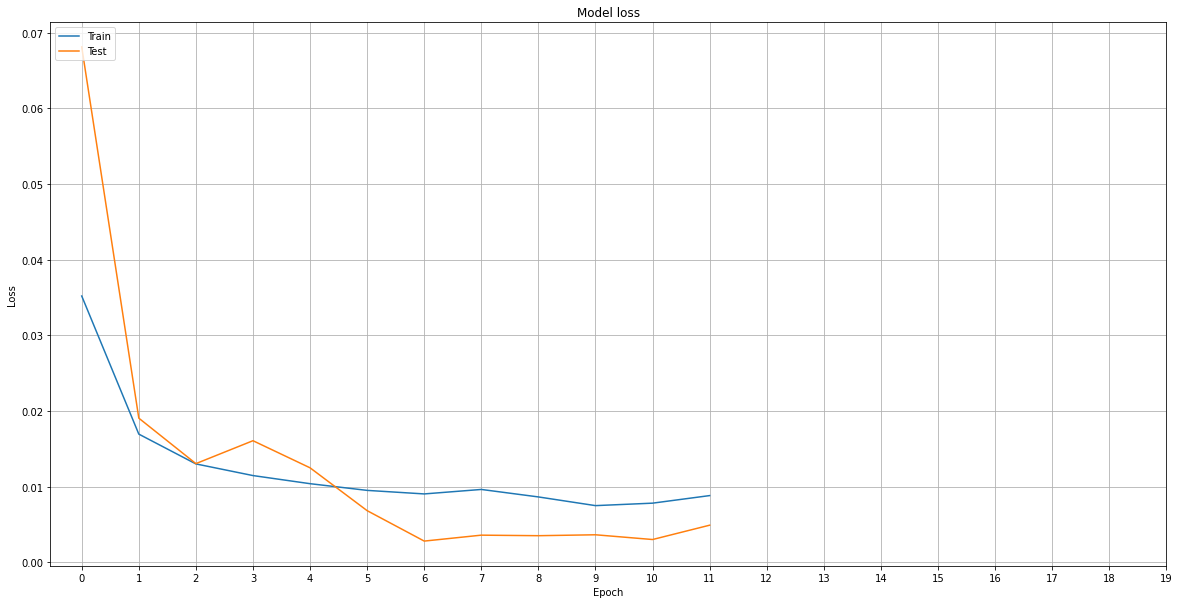

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.74
Mean Absolute Percentage Error (MAPE): 14.6 %
Median Absolute Percentage Error (MDAPE): 12.91 %


,MAE,MAPE,MDAPE
0,0.738326,14.599592,12.912575


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

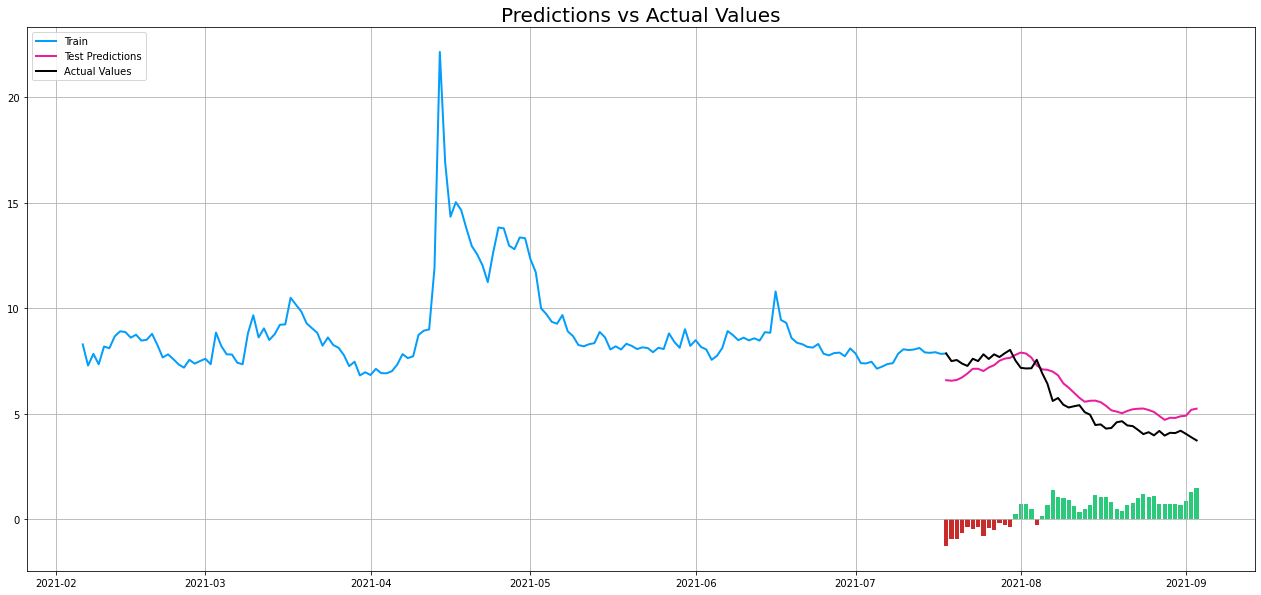

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: CLOV Daily%Change

### Without Normalization

In [25]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '5Dir', 'Close', '2D%Change', '4Dir', '3D%Change', 'Open', '7D%Change', 'Low', 'Dir', '6D%Change', '7Dir', '4D%Change', '2Dir', '6Dir', '3Dir', 'Volume', '5D%Change', 'SD_log', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
3,-4.240765,2,-2.403202,0.0,15606600.0,0.0,14.86,0.619409,14.270,-12.820516,...,-8.050313,0.999128,1.0,-8.739079,0.0,0.0,-3.114647,2.715913,-6.342087,14.62
4,0.071430,3,-4.240765,0.0,13886000.0,0.0,14.56,-12.609241,13.800,-10.313899,...,-6.542053,0.138233,0.0,-11.949683,0.0,0.0,-3.647624,1.148243,-7.223328,14.00
5,-5.496077,4,0.071430,0.0,13765600.0,1.0,14.15,-11.886789,13.570,-7.157057,...,-4.172364,0.606492,0.0,-6.475296,0.0,0.0,-12.546818,1.833987,-3.578799,14.01
6,3.851966,1,-5.496077,0.0,13851400.0,0.0,13.87,-11.615486,13.100,-8.878183,...,-5.428573,0.436696,0.0,-9.439125,0.0,0.0,-16.729559,1.547585,-17.353312,13.24
7,-0.145458,2,3.851966,0.0,13329600.0,1.0,13.69,-5.950752,13.271,-14.169790,...,-1.855819,0.395507,0.0,-1.785714,0.0,0.0,-8.210945,1.485137,-13.522011,13.75


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
241,-0.243896,2,3.274556,1.0,10732300.0,1.0,4.020,-0.726397,3.990,-7.239823,...,-0.001667,0.0,3.015072,0.0,0.0,1.485147,0.998334,-3.301884,4.10,-0.243896
242,2.689478,3,-0.243896,0.0,7689900.0,0.0,4.083,2.763822,4.040,-3.537727,...,-0.194293,1.0,-2.386633,0.0,1.0,-0.968522,0.823417,1.237628,4.09,2.689478
243,-3.571420,0,2.689478,1.0,8830600.0,1.0,4.080,0.238658,4.050,3.960392,...,-0.382827,1.0,5.793445,1.0,1.0,5.527633,0.681931,1.694908,4.20,-3.571420
244,-3.950619,1,-3.571420,0.0,7262200.0,0.0,4.160,2.015117,4.025,-1.937044,...,0.087610,1.0,-1.219505,0.0,1.0,-3.341286,1.091562,1.758798,4.05,-3.950619
245,-3.856043,2,-3.950619,0.0,10949100.0,0.0,4.017,-5.121946,3.835,-2.261304,...,-0.075867,0.0,-4.889977,0.0,0.0,-2.015111,0.926939,-7.159903,3.89,-3.856043


In [27]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.24138927906620639
0.24138927906620639


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'CLOV_woSentiment_DailyChange_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0185
Epoch 1: val_loss improved from inf to 0.00179, saving model to CLOV_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 5s 96ms/step - loss: 0.0182 - val_loss: 0.0018
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0097
Epoch 2: val_loss did not improve from 0.00179
12/12 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0022
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0068
Epoch 3: val_loss did not improve from 0.00179
12/12 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss did not improve from 0.00179
12/12 [==============================] - 0s 16ms/step - loss: 0.0073 - val_loss: 0.0021
Epoch 5/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0071
Epoch 5: val_lo

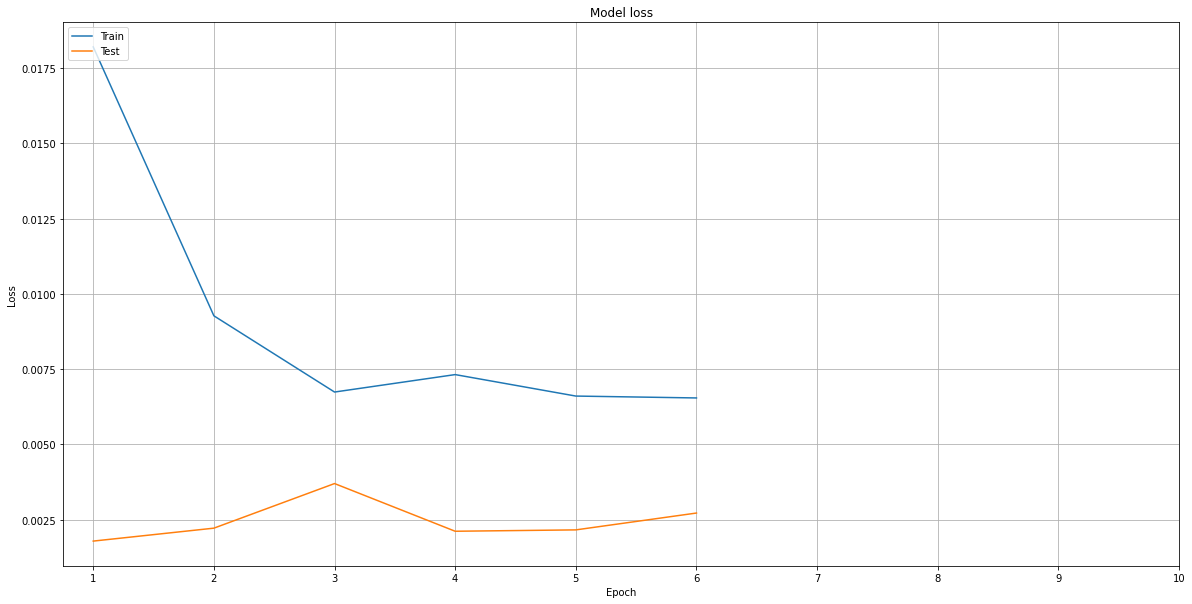

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 3.91
Mean Absolute Percentage Error (MAPE): 266.46 %
Median Absolute Percentage Error (MDAPE): 107.78 %


,MAE,MAPE,MDAPE
0,3.906001,266.462774,107.779329


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

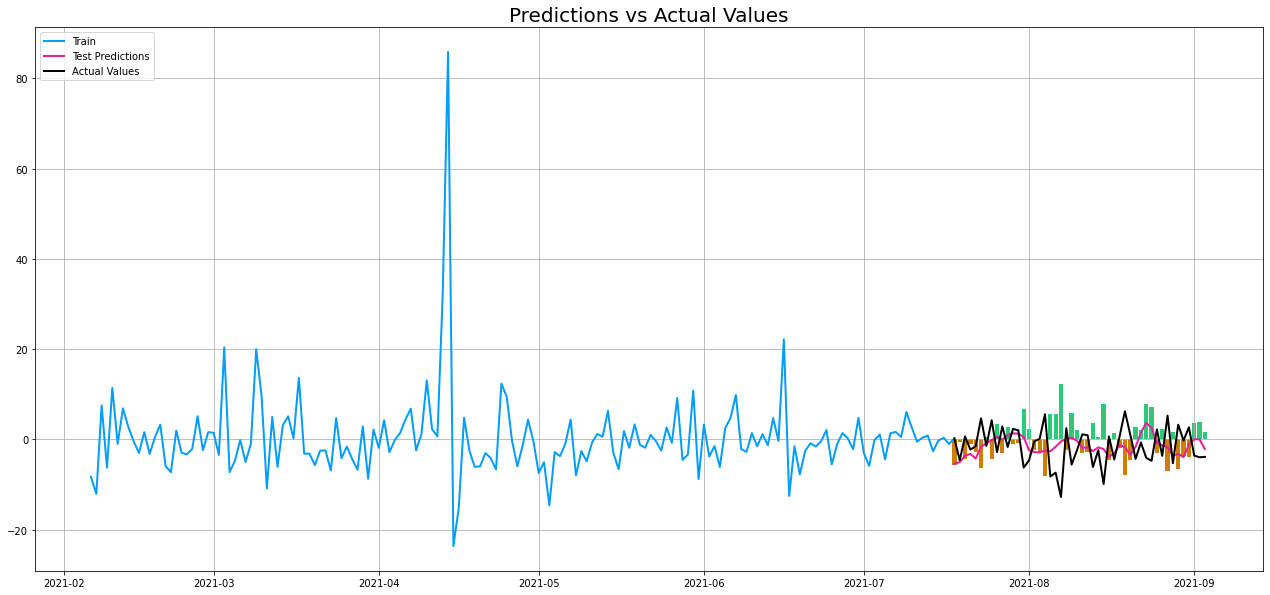

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [35]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '5Dir', 'Close', '2D%Change', '4Dir', '3D%Change', 'Open', '7D%Change', 'Low', 'Dir', '6D%Change', '7Dir', '4D%Change', '2Dir', '6Dir', '3Dir', 'Volume', '5D%Change', 'SD_log', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
3,-4.240765,2,-2.403202,0.0,15606600.0,0.0,14.86,0.619409,14.270,-12.820516,...,-8.050313,0.999128,1.0,-8.739079,0.0,0.0,-3.114647,2.715913,-6.342087,14.62
4,0.071430,3,-4.240765,0.0,13886000.0,0.0,14.56,-12.609241,13.800,-10.313899,...,-6.542053,0.138233,0.0,-11.949683,0.0,0.0,-3.647624,1.148243,-7.223328,14.00
5,-5.496077,4,0.071430,0.0,13765600.0,1.0,14.15,-11.886789,13.570,-7.157057,...,-4.172364,0.606492,0.0,-6.475296,0.0,0.0,-12.546818,1.833987,-3.578799,14.01
6,3.851966,1,-5.496077,0.0,13851400.0,0.0,13.87,-11.615486,13.100,-8.878183,...,-5.428573,0.436696,0.0,-9.439125,0.0,0.0,-16.729559,1.547585,-17.353312,13.24
7,-0.145458,2,3.851966,0.0,13329600.0,1.0,13.69,-5.950752,13.271,-14.169790,...,-1.855819,0.395507,0.0,-1.785714,0.0,0.0,-8.210945,1.485137,-13.522011,13.75


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
241,-0.243896,2,3.274556,1.0,10732300.0,1.0,4.020,-0.726397,3.990,-7.239823,...,-0.001667,0.0,3.015072,0.0,0.0,1.485147,0.998334,-3.301884,4.10,-0.243896
242,2.689478,3,-0.243896,0.0,7689900.0,0.0,4.083,2.763822,4.040,-3.537727,...,-0.194293,1.0,-2.386633,0.0,1.0,-0.968522,0.823417,1.237628,4.09,2.689478
243,-3.571420,0,2.689478,1.0,8830600.0,1.0,4.080,0.238658,4.050,3.960392,...,-0.382827,1.0,5.793445,1.0,1.0,5.527633,0.681931,1.694908,4.20,-3.571420
244,-3.950619,1,-3.571420,0.0,7262200.0,0.0,4.160,2.015117,4.025,-1.937044,...,0.087610,1.0,-1.219505,0.0,1.0,-3.341286,1.091562,1.758798,4.05,-3.950619
245,-3.856043,2,-3.950619,0.0,10949100.0,0.0,4.017,-5.121946,3.835,-2.261304,...,-0.075867,0.0,-4.889977,0.0,0.0,-2.015111,0.926939,-7.159903,3.89,-3.856043


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.24138927906620639
0.24138927906620639


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'CLOV_woSentiment_DailyChange_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0348
Epoch 1: val_loss improved from inf to 0.00219, saving model to CLOV_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 5s 95ms/step - loss: 0.0311 - val_loss: 0.0022
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0090
Epoch 2: val_loss did not improve from 0.00219
12/12 [==============================] - 0s 16ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 3/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0088
Epoch 3: val_loss did not improve from 0.00219
12/12 [==============================] - 0s 17ms/step - loss: 0.0083 - val_loss: 0.0023
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0074
Epoch 4: val_loss improved from 0.00219 to 0.00185, saving model to CLOV_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 22ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 5/100
 9/12 [=============

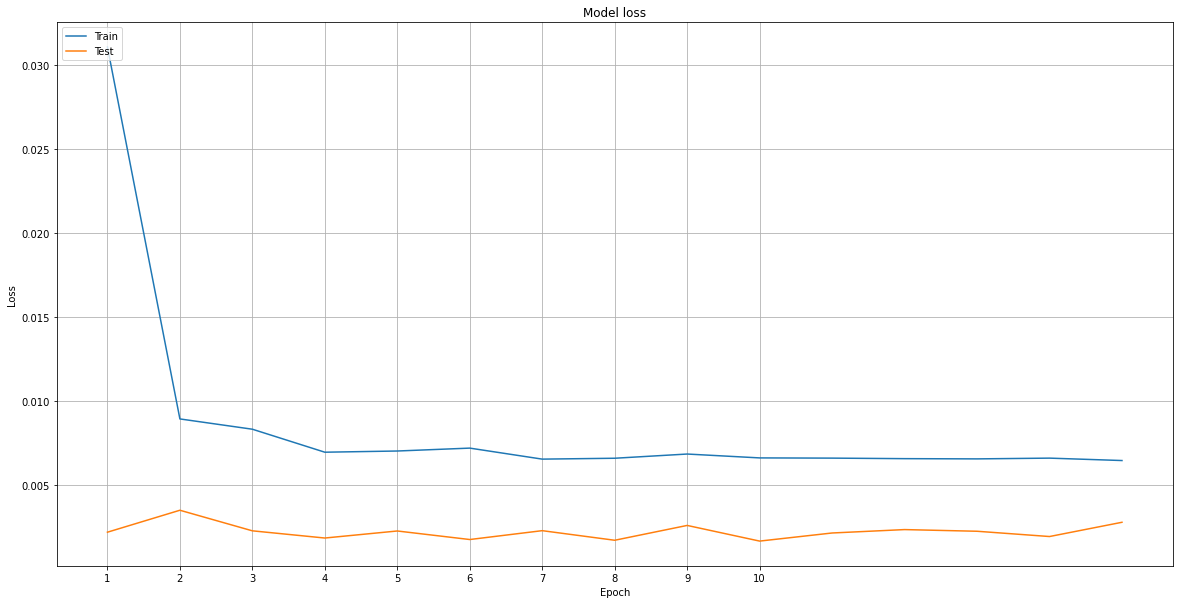

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 3.73
Mean Absolute Percentage Error (MAPE): 152.21 %
Median Absolute Percentage Error (MDAPE): 110.61 %


,MAE,MAPE,MDAPE
0,3.726741,152.207209,110.607896


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

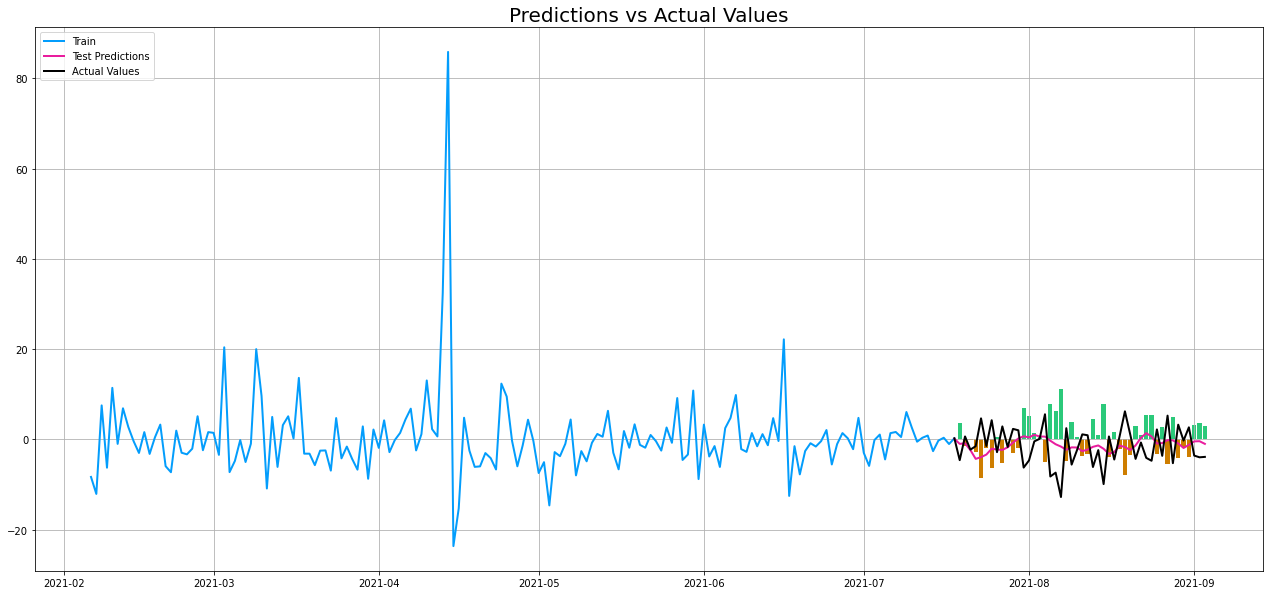

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: CLOV SD

### Without Normalization

In [45]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5Dir', 'Close', '2D%Change', '4Dir', '3D%Change', 'Open', '7D%Change', 'Low', 'Dir', '6D%Change', 'Daily%Change', '7Dir', '4D%Change', '2Dir', '6Dir', '3Dir', 'Volume', '5D%Change', 'SD_log', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
3,1.148243,2,-2.403202,0.0,15606600.0,0.0,14.86,0.619409,14.270,-12.820516,...,-8.050313,0.999128,1.0,-8.739079,0.0,0.0,-3.114647,2.715913,-6.342087,14.62
4,1.833987,3,-4.240765,0.0,13886000.0,0.0,14.56,-12.609241,13.800,-10.313899,...,-6.542053,0.138233,0.0,-11.949683,0.0,0.0,-3.647624,1.148243,-7.223328,14.00
5,1.547585,4,0.071430,0.0,13765600.0,1.0,14.15,-11.886789,13.570,-7.157057,...,-4.172364,0.606492,0.0,-6.475296,0.0,0.0,-12.546818,1.833987,-3.578799,14.01
6,1.485137,1,-5.496077,0.0,13851400.0,0.0,13.87,-11.615486,13.100,-8.878183,...,-5.428573,0.436696,0.0,-9.439125,0.0,0.0,-16.729559,1.547585,-17.353312,13.24
7,0.632621,2,3.851966,0.0,13329600.0,1.0,13.69,-5.950752,13.271,-14.169790,...,-1.855819,0.395507,0.0,-1.785714,0.0,0.0,-8.210945,1.485137,-13.522011,13.75


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
241,0.823417,2,3.274556,1.0,10732300.0,1.0,4.020,-0.726397,3.990,-7.239823,...,-0.001667,0.0,3.015072,0.0,0.0,1.485147,0.998334,-3.301884,4.10,0.823417
242,0.681931,3,-0.243896,0.0,7689900.0,0.0,4.083,2.763822,4.040,-3.537727,...,-0.194293,1.0,-2.386633,0.0,1.0,-0.968522,0.823417,1.237628,4.09,0.681931
243,1.091562,0,2.689478,1.0,8830600.0,1.0,4.080,0.238658,4.050,3.960392,...,-0.382827,1.0,5.793445,1.0,1.0,5.527633,0.681931,1.694908,4.20,1.091562
244,0.926939,1,-3.571420,0.0,7262200.0,0.0,4.160,2.015117,4.025,-1.937044,...,0.087610,1.0,-1.219505,0.0,1.0,-3.341286,1.091562,1.758798,4.05,0.926939
245,1.468468,2,-3.950619,0.0,10949100.0,0.0,4.017,-5.121946,3.835,-2.261304,...,-0.075867,0.0,-4.889977,0.0,0.0,-2.015111,0.926939,-7.159903,3.89,1.468468


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.08631917867697754
0.08631917867697754


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'CLOV_woSentiment_SD_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0178
Epoch 1: val_loss improved from inf to 0.00367, saving model to CLOV_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 5s 106ms/step - loss: 0.0144 - val_loss: 0.0037
Epoch 2/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0081
Epoch 2: val_loss improved from 0.00367 to 0.00137, saving model to CLOV_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 3/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0075
Epoch 3: val_loss did not improve from 0.00137
12/12 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0017
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0081
Epoch 4: val_loss did not improve from 0.00137
12/12 [==============================] - 0s 18ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 5/100
 9/12 [====================

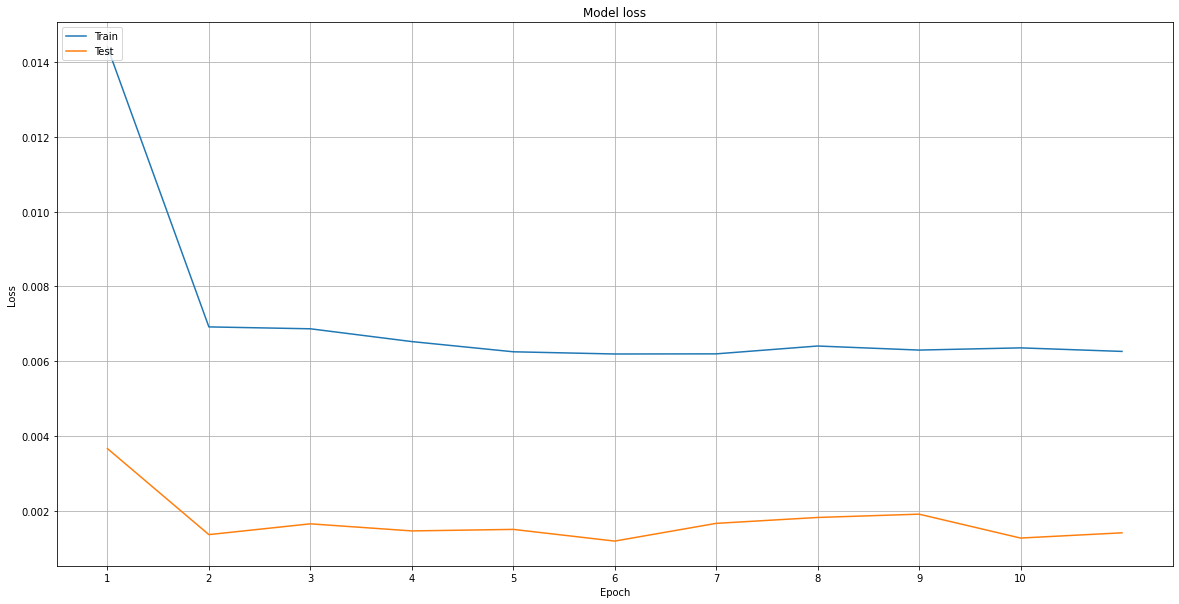

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.73
Mean Absolute Percentage Error (MAPE): 78.05 %
Median Absolute Percentage Error (MDAPE): 40.21 %


,MAE,MAPE,MDAPE
0,0.72594,78.046695,40.205769


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

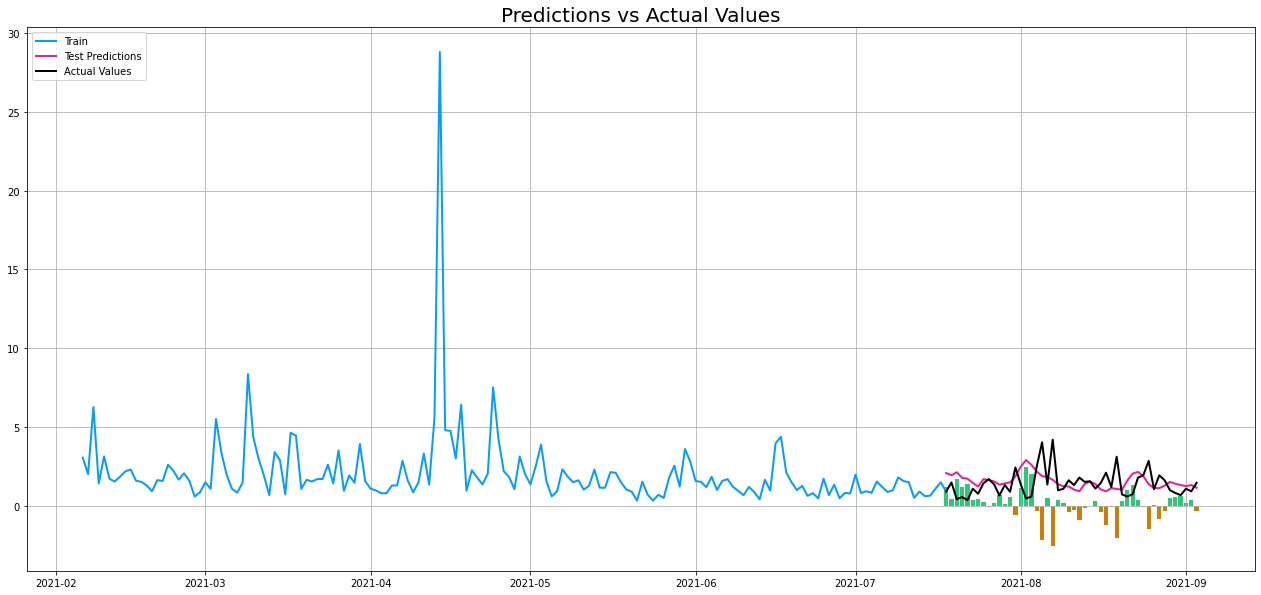

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [55]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5Dir', 'Close', '2D%Change', '4Dir', '3D%Change', 'Open', '7D%Change', 'Low', 'Dir', '6D%Change', 'Daily%Change', '7Dir', '4D%Change', '2Dir', '6Dir', '3Dir', 'Volume', '5D%Change', 'SD_log', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
3,1.148243,2,-2.403202,0.0,15606600.0,0.0,14.86,0.619409,14.270,-12.820516,...,-8.050313,0.999128,1.0,-8.739079,0.0,0.0,-3.114647,2.715913,-6.342087,14.62
4,1.833987,3,-4.240765,0.0,13886000.0,0.0,14.56,-12.609241,13.800,-10.313899,...,-6.542053,0.138233,0.0,-11.949683,0.0,0.0,-3.647624,1.148243,-7.223328,14.00
5,1.547585,4,0.071430,0.0,13765600.0,1.0,14.15,-11.886789,13.570,-7.157057,...,-4.172364,0.606492,0.0,-6.475296,0.0,0.0,-12.546818,1.833987,-3.578799,14.01
6,1.485137,1,-5.496077,0.0,13851400.0,0.0,13.87,-11.615486,13.100,-8.878183,...,-5.428573,0.436696,0.0,-9.439125,0.0,0.0,-16.729559,1.547585,-17.353312,13.24
7,0.632621,2,3.851966,0.0,13329600.0,1.0,13.69,-5.950752,13.271,-14.169790,...,-1.855819,0.395507,0.0,-1.785714,0.0,0.0,-8.210945,1.485137,-13.522011,13.75


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
241,0.823417,2,3.274556,1.0,10732300.0,1.0,4.020,-0.726397,3.990,-7.239823,...,-0.001667,0.0,3.015072,0.0,0.0,1.485147,0.998334,-3.301884,4.10,0.823417
242,0.681931,3,-0.243896,0.0,7689900.0,0.0,4.083,2.763822,4.040,-3.537727,...,-0.194293,1.0,-2.386633,0.0,1.0,-0.968522,0.823417,1.237628,4.09,0.681931
243,1.091562,0,2.689478,1.0,8830600.0,1.0,4.080,0.238658,4.050,3.960392,...,-0.382827,1.0,5.793445,1.0,1.0,5.527633,0.681931,1.694908,4.20,1.091562
244,0.926939,1,-3.571420,0.0,7262200.0,0.0,4.160,2.015117,4.025,-1.937044,...,0.087610,1.0,-1.219505,0.0,1.0,-3.341286,1.091562,1.758798,4.05,0.926939
245,1.468468,2,-3.950619,0.0,10949100.0,0.0,4.017,-5.121946,3.835,-2.261304,...,-0.075867,0.0,-4.889977,0.0,0.0,-2.015111,0.926939,-7.159903,3.89,1.468468


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.08631917867697754
0.08631917867697754


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'CLOV_woSentiment_SD_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0471
Epoch 1: val_loss improved from inf to 0.01095, saving model to CLOV_woSentiment_SD_Normalized.h5
12/12 [==============================] - 5s 104ms/step - loss: 0.0392 - val_loss: 0.0110
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0095
Epoch 2: val_loss improved from 0.01095 to 0.00136, saving model to CLOV_woSentiment_SD_Normalized.h5
12/12 [==============================] - 0s 20ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss did not improve from 0.00136
12/12 [==============================] - 0s 20ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0085
Epoch 4: val_loss improved from 0.00136 to 0.00132, saving model to CLOV_woSentiment_SD_Normalized.h5
12/12 [==============================] - 0s 31ms/step - loss: 0.0071 - val_loss: 0

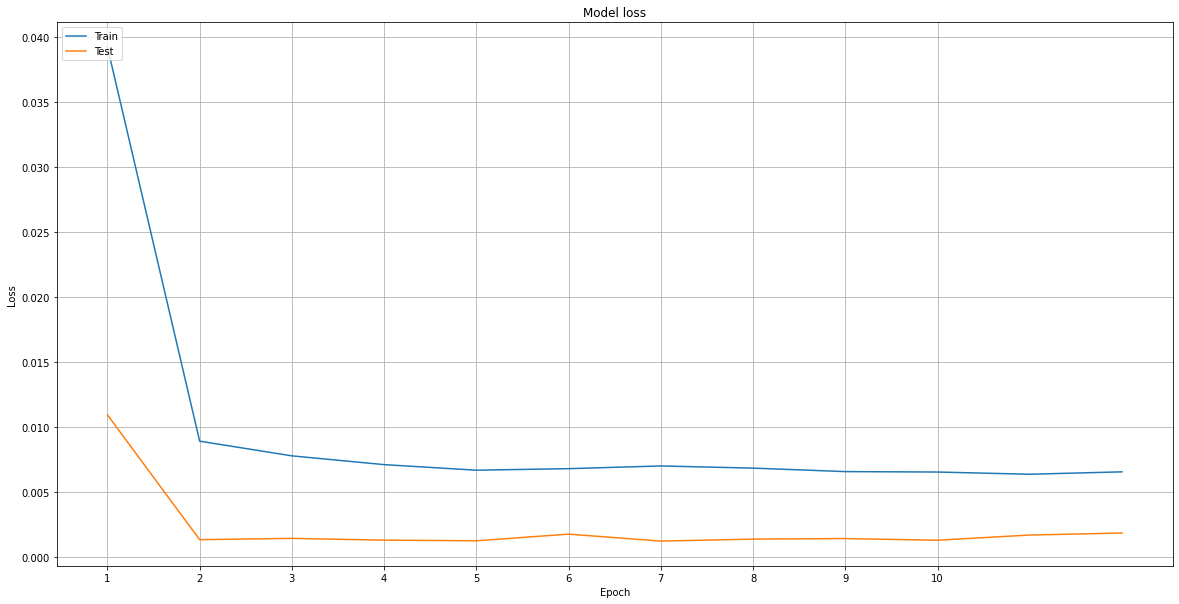

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.75
Mean Absolute Percentage Error (MAPE): 86.27 %
Median Absolute Percentage Error (MDAPE): 44.75 %


,MAE,MAPE,MDAPE
0,0.752865,86.266915,44.754613


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

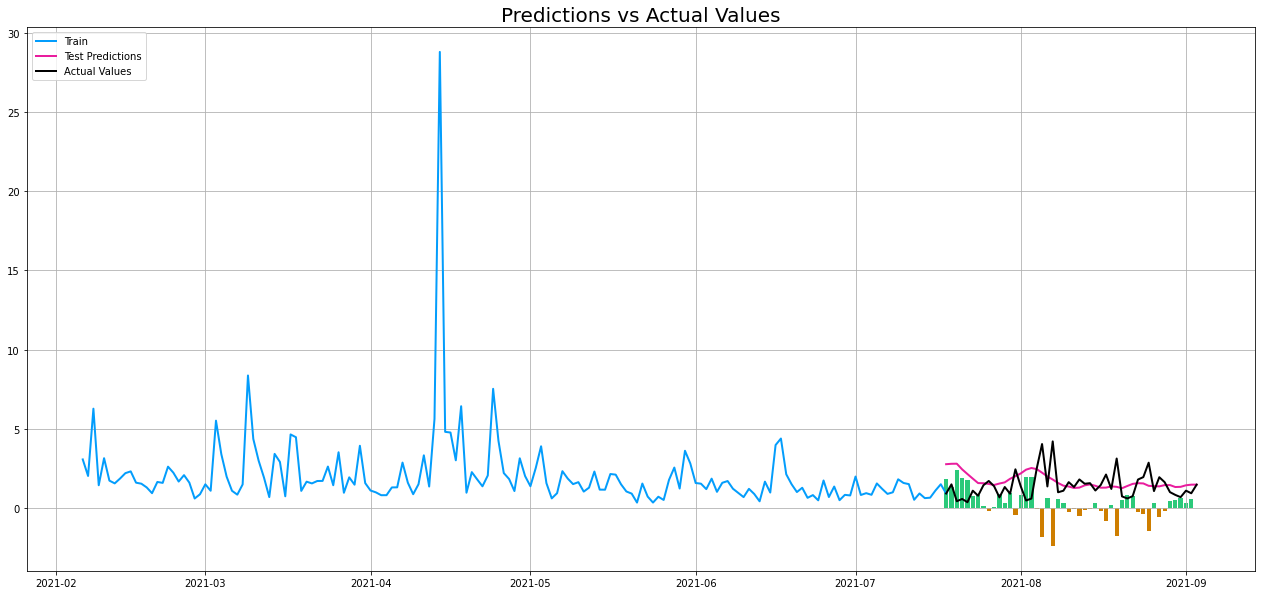

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()